In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier
import random

In [2]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        # 确保所有列都存在
        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        # **🔥 强制 z-score 归一化**
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)

        # 防止标准差为 0，避免 NaN
        std[std == 0] = 1e-8  
        
        #signal = (signal - mean) / std  # 归一化
        
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis

In [3]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.mixture import GaussianMixture

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None, target_length=600, 
                 strategy='padding', padding_mode="gmm", use_labels=False, augment=False,
                 num_good=1, num_bad=1, column_names=['spike hz'], max_components=100):
        
        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment
        self.column_names = column_names
        self.num_good = num_good
        self.num_bad = num_bad
        self.max_components = max_components  # 自动选择 GMM 组件数

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

        # **初始化 outcome_dict，防止 AttributeError**
        self.outcome_dict = {}

        if use_labels and outcome_file:
            outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = outcome_data.set_index('pat_ID')['outcome'].to_dict()

        # **训练 GMM**
        self.gmm = self.train_gmm(data_folder, column_names, max_components)

    def get_label(self, patient_id):
        """ 获取样本标签 """
        return 1 if self.use_labels and patient_id in self.outcome_dict and self.outcome_dict[patient_id] == "Good Outcome" else 0

    def train_gmm(self, data_folder, column_names, max_components):
        """ 自动选择最优 GMM 组件数，并训练 GMM """
        all_data = []
        for f in self.file_list:
            file_path = os.path.join(data_folder, f)
            signal = EEGUtil.load_data(file_path, column_names=column_names)
            all_data.append(signal.flatten())  # 展平成 1D 以训练 GMM
        
        all_data = np.concatenate(all_data).reshape(-1, 1)  # 转换为 GMM 输入格式

        # **自动选择 GMM 组件数**
        best_gmm, best_n = self.find_optimal_gmm(all_data, max_components)
        print(f"✅ GMM 训练完成，最佳 n_components={best_n}")
        return best_gmm

    def find_optimal_gmm(self, data, max_components=10):
        """ 选择最优的 GMM 组件数，基于 BIC 评估 """
        bic_scores = []
        models = []

        for n in range(1, max_components + 1):  # 试 1 到 max_components 个高斯分布
            gmm = GaussianMixture(n_components=n, random_state=42)
            gmm.fit(data)
            models.append(gmm)
            bic_scores.append(gmm.bic(data))  # 计算 BIC

        # 选择 BIC 最小的 n_components
        best_n = np.argmin(bic_scores) + 1  
        best_gmm = models[best_n - 1]
        return best_gmm, best_n

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        file_path = os.path.join(self.data_folder, filename)

        signal = EEGUtil.load_data(file_path, column_names=self.column_names)
        patient_id = filename.split('.')[0]
        label = self.get_label(patient_id) if self.use_labels else -1

        aligned_signal = self.align_signal(signal)

        return torch.tensor(aligned_signal, dtype=torch.float32), label
    
    def align_signal(self, signal):
        """ 对 EEG 数据进行对齐，并使用 GMM 填充 """
        target_length = self.target_length
        total_signal_length = signal.shape[1]

        if total_signal_length < target_length:
            signal = self.pad_signal(signal, target_length, mode="gmm", gmm=self.gmm)

        return signal[:, :target_length]

    @staticmethod
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post", gmm=None):
        """ 使用 GMM 填充缺失数据 """
        channels, current_length = signal.shape

        if current_length >= target_length:
            return signal[:, :target_length]  # 超长则裁剪

        padding_size = target_length - current_length

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "gmm":
            """ 使用 GMM 采样填充 """
            if gmm is None:
                raise ValueError("GMM 模型未定义，无法使用 GMM 填充")
            if padding_size > 0:
                pad_values = gmm.sample(n_samples=padding_size)[0].T  # 采样并转置匹配 shape
            else:
                pad_values = np.zeros((channels, 0))  # 避免 `padding_size=0` 时出错
        else:
            raise ValueError(f"不支持的填充模式: {mode}")

        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))
        else:
            padded_signal = np.hstack((signal, pad_values))

        return padded_signal[:, :target_length]

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_augmented_samples(dataset, num_samples=5):
    """
    随机选择 num_samples 个 EEG 样本并可视化 **多通道** 波形
    
    参数:
    - dataset: EEGDataset 实例
    - num_samples: 需要可视化的样本数
    """
    # 🚀 直接从 dataset 获取样本
    sample, _ = dataset[0]  # 获取第一个样本，检查 shape
    num_channels, num_timepoints = sample.shape  # 🚀 获取通道数和时间点数

    fig, axes = plt.subplots(num_samples, num_channels, figsize=(10, 2 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 处理单个样本的情况
    if num_channels == 1:
        axes = np.expand_dims(axes, axis=1)  # 处理单通道情况

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # 随机选择样本
        sample, label = dataset[idx]  # 获取样本
        sample = sample.numpy()  # 🚀 变回 NumPy 数组，shape: (num_channels, 时间步)

        start_time = 16  # 开始时间 (小时)
        time_axis = np.linspace(start_time, start_time + (num_timepoints - 1) * 5 / 60, num_timepoints)

        for ch in range(num_channels):  # 🚀 遍历每个通道
            axes[i, ch].plot(time_axis, sample[ch], label=f"Ch {ch+1}", alpha=0.8)
            axes[i, ch].set_title(f"Sample {i+1} - Ch {ch+1} (Label: {label})")
            axes[i, ch].set_xlabel("Time (hours)")
            axes[i, ch].set_ylabel("Amplitude")
            axes[i, ch].grid(True)

    plt.tight_layout()
    plt.show()

/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


✅ GMM 训练完成，最佳 n_components=99


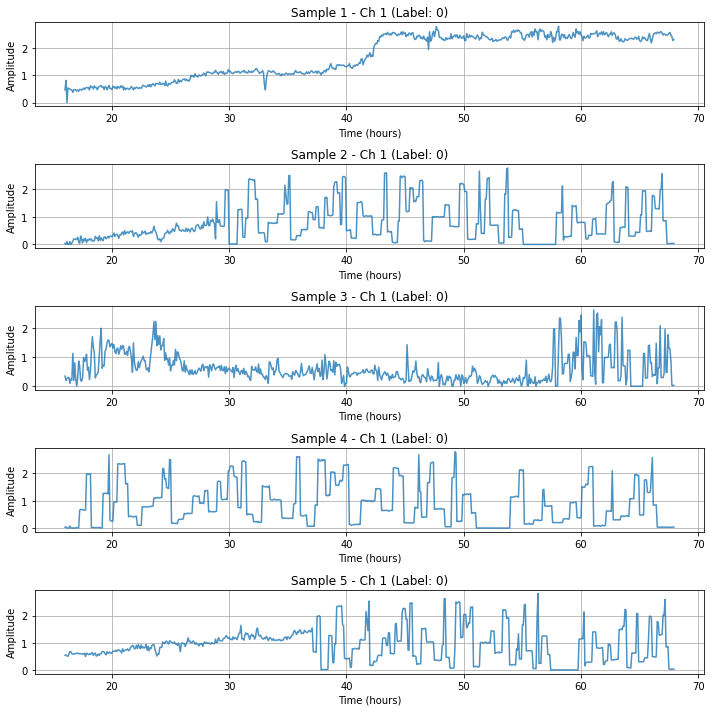

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter settings
latent_dim = 100  # Dimension of the latent space
initial_channels = 128  # Initial number of channels for CNN
seq_length = (68 - 16) * 12  # Number of `5min` windows for 52 hours (624)
batch_size = 32
epochs = 100
alpha = 1e-6  # Weight for KL loss
patience = 10  # Define the number of epochs without improvement before stopping training
padding_method = 'constant'  # Use constant padding
is_augment = True  # Enable data augmentation
num_good_train=1
num_bad_train=1
num_good_test=1
num_bad_test=1
column_names=['spike hz']
num_eeg_channels = len(column_names)

is_VAEtrain_aug=False

# Define dataset folder paths
data_folder = '5min_smoothed_data/'  # Replace with the actual data folder path
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file = 'files_art_ssd_fts_predictions.csv'

# Create EEG dataset (labels are not used when training VAE)
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # Use labels to determine class-based augmentation
    augment=False,  # Enable data augmentation
    num_good=1,
    num_bad=1,
    column_names=column_names
)

visualize_augmented_samples(eeg_dataset, num_samples=5)  # Random Visualize 5 sapmle

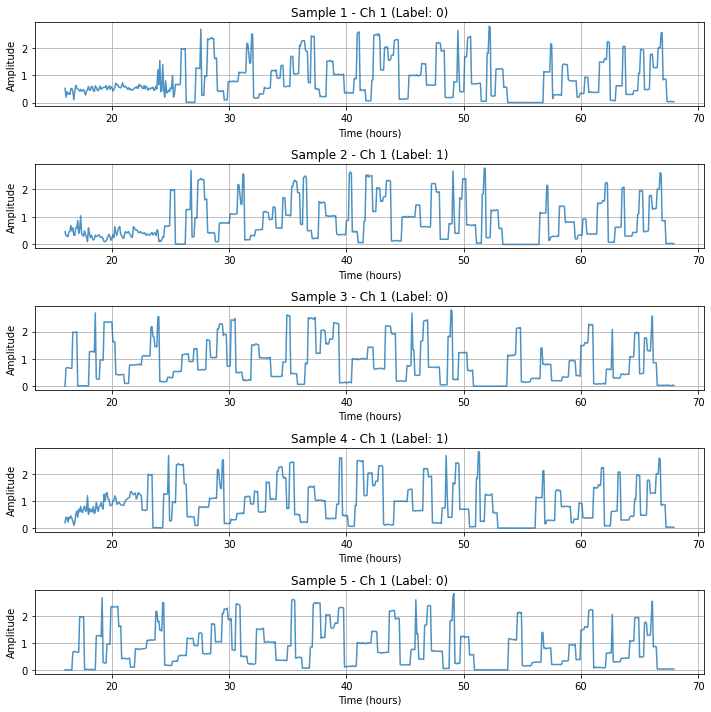

In [8]:
visualize_augmented_samples(eeg_dataset, num_samples=5)  # Random Visualize 5 sapmle

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import pywt
from scipy.signal import welch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [ ]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        # 确保所有列都存在
        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        # **🔥 强制 z-score 归一化**
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)

        # 防止标准差为 0，避免 NaN
        std[std == 0] = 1e-8  
        
        #signal = (signal - mean) / std  # 归一化
        
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis

In [38]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz']):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment # 是否启用数据增强
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < 16 * 3600 or start_time > 68 * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (16 * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=0, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                # **向右平移: 在前面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                # **向左平移: 在后面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                # **不平移，直接填充**
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)  
        )

    def forward(self, x):
        params = self.encoder(x)
        mu, log_var = torch.chunk(params, 2, dim=-1)  
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std  
        return self.decoder(z), mu, log_var  

def train_vae(dataloader, input_dim, epochs=50, latent_dim=16):
    vae = VAE(input_dim, latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for x in dataloader:
            x = x.float()
            x_hat, mu, log_var = vae(x)
            recon_loss = loss_fn(x_hat, x)  
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  
            loss = recon_loss + 0.01 * kl_loss  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader)}")

    torch.save(vae.state_dict(), "vae_model.pth")
    return vae

In [40]:
def vae_impute(vae, signal):
    """ Use trained VAE to fill missing values. """
    missing_idx = np.where(np.isnan(signal))
    if len(missing_idx[0]) > 0:
        input_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
        output_tensor, _, _ = vae(input_tensor)
        signal[missing_idx] = output_tensor.squeeze(0).detach().numpy()[missing_idx]
    return signal

In [41]:
# 定义数据集路径
data_folder = '5min_smoothed_data/'  # 确保这个文件夹存在
valid_outcome_data = 'valid_patients_outcome.csv'  # 可选
ssd_file = 'files_art_ssd_fts_predictions.csv'  # 确保文件存在

# 创建 EEG 数据集
eeg_dataset = EEGDataset(
    data_folder=data_folder,
    ssd_file=ssd_file,
    target_length=600,  
    padding_mode="vae",  # 选择 VAE 进行填充
    column_names=['spike hz']  
)

# 确保数据集能正常工作
print(f"Dataset length: {len(eeg_dataset)}")
sample_data = eeg_dataset[0]
print(f"Sample shape: {sample_data.shape}")

✅ Loaded 540 EEG files
Dataset length: 540
Sample shape: torch.Size([1, 600])
